In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *
import os
from src.utils import *


In [3]:
from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform
from sklearn.utils import shuffle
# import train_test_split
from sklearn.model_selection import train_test_split

In [8]:
import pickle

In [4]:
np.isnan(torch.tensor(2).item())


False

In [4]:
#os.environ["CUDA_VISIBLE_DEVICES"]='2'


CUDA = True
device = torch.device("cuda:0" if CUDA else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if CUDA else {}
kwargs = {}


In [6]:
cd ..

/home/rd804/m-anode


In [7]:
# define nan


In [9]:
with open('data/data.pkl', 'rb') as f:
    data = pickle.load(f)

back_mean = 0
sig_mean = 3
sig_simga = 0.5
back_sigma = 3

with open('data/true_w.pkl', 'rb') as f:
    true_w = pickle.load(f)

with open('data/background.pkl', 'rb') as f:
    background = pickle.load(f)


# fit train data
best_parameters = {}
run = 0

sig_train = 10

best_parameters[str(sig_train)] = {}

# Load train data
x_train = data[str(sig_train)]['train']['data']

_X_train = np.concatenate((x_train, background), axis=0)
_y_train = np.concatenate((np.ones(len(x_train)), np.zeros(len(background))), axis=0)






_X_train, _y_train  = shuffle(_X_train, _y_train, random_state=10)


X_train , X_val = train_test_split(_X_train, test_size=0.5, random_state=22)
y_train , y_val = train_test_split(_y_train, test_size=0.5, random_state=22)


In [33]:
len(y_train[y_train==0])

49880

In [19]:
x_test = data['10']['val']['data']
label_test = data['10']['val']['label']

testtensor = torch.from_numpy(x_test.reshape(-1,1)).float()


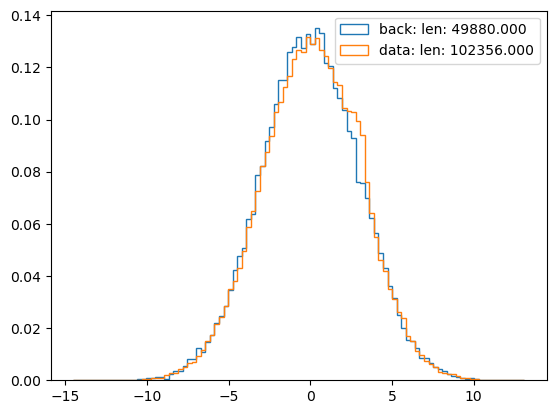

In [11]:
bins = np.linspace(min(X_train), max(X_train), 100)

plt.hist(X_train[y_train==0], bins=bins, label='back: len: %.3f' % len(X_train[y_train==0]) , density=True, histtype='step')
plt.hist(X_train[y_train==1], bins=bins, label='data: len: %.3f' % len(X_train[y_train==1]), density=True, histtype='step')
plt.legend()
#plt.hist(, bins=100, alpha=0.5, label='val', density=True, histtype='step')
plt.show()

In [12]:
# define X_train y_train to be used for loading to dataloader

batch_size = 128

X_train = torch.from_numpy(X_train.reshape(-1,1)).float()
y_train = torch.from_numpy(y_train.reshape(-1,1)).float()

X_val = torch.from_numpy(X_val.reshape(-1,1)).float()
y_val = torch.from_numpy(y_val.reshape(-1,1)).float()

traindataset = torch.utils.data.TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)

valdataset = torch.utils.data.TensorDataset(X_val, y_val)
valloader = torch.utils.data.DataLoader(valdataset, batch_size=batch_size*5, shuffle=False)



In [38]:
pwd

'/home/rd804/m-anode'

In [13]:
model_S=define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0, device=device)
model_B=define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0, device=device)

w = torch.tensor(0.0, requires_grad=True, device=device)

#optimizer = torch.optim.Adam(list(model_S.parameters()) + list(model_B.parameters()) + [w], lr=1e-3)

In [14]:

valloss = np.load('results/nflows_gaussian_mixture_1/CR/try_0/valloss_list_background.npy')

index = np.argmin(valloss).flatten()[0]

model_B.load_state_dict(torch.load(f'results/nflows_gaussian_mixture_1/CR/try_0/model_CR_{index}.pt'))


optimizer = torch.optim.Adam(list(model_S.parameters())  + [w], lr=1e-3)

In [51]:
valloss = []
trainloss = []

for epoch in range(10):

    train_loss = m_anode(model_S,model_B,w,optimizer,trainloader,noise_data=0,noise_context=0, device=device, mode='train',
                            mode_background='fixed',
                         clip_grad=False)
    val_loss = m_anode(model_S,model_B,w,optimizer,valloader,noise_data=0,noise_context=0, device=device, mode='val',
                            mode_background='fixed')

    valloss.append(val_loss)
    trainloss.append(train_loss)

    print('epoch: %d, train_loss: %.3f, val_loss: %.3f' % (epoch, train_loss, val_loss))
    print('w: %.3f' % w.item())

 #   if epoch % 5 == 0:
  #      torch.save(model_S.state_dict(), 'models/model_S_%d_%d.pth' % (sig_train, epoch))
   #     torch.save(model_B.state_dict(), 'models/model_B_%d_%d.pth' % (sig_train, epoch))
    #    torch.save(w, 'models/w_%d_%d.pth' % (sig_train, epoch))




epoch: 0, train_loss: 390976.597, val_loss: 392487.828
w: -0.320
epoch: 1, train_loss: 390414.310, val_loss: 391881.202
w: -0.650
epoch: 2, train_loss: 390266.818, val_loss: 391984.467
w: -0.914
epoch: 3, train_loss: 390230.979, val_loss: 391814.596
w: -1.158
epoch: 4, train_loss: 390210.630, val_loss: 391820.666
w: -1.369
epoch: 5, train_loss: 390181.131, val_loss: 391784.451
w: -1.513
epoch: 6, train_loss: 390157.150, val_loss: 391855.579
w: -1.635
epoch: 7, train_loss: 390154.749, val_loss: 391819.409
w: -1.736
epoch: 8, train_loss: 390147.432, val_loss: 391866.904
w: -1.838
epoch: 9, train_loss: 390153.841, val_loss: 391829.801
w: -1.917


In [15]:
model_B.eval()
model_S.eval()

param_s_sum = 0
param_b_sum = 0

for (param_S, param_B) in zip(model_S.parameters(), model_B.parameters()):
    param_S.requires_grad = False
    param_B.requires_grad = False

    param_s_sum += param_S.sum()
    param_b_sum += param_B.sum()

print(param_s_sum, param_b_sum)



tensor(106.4310, device='cuda:0') tensor(103.8215, device='cuda:0')


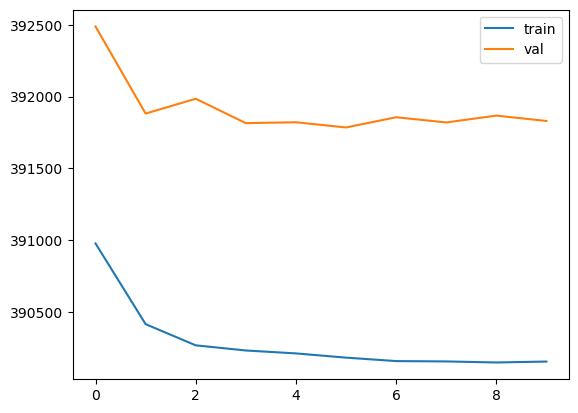

In [52]:
plt.plot(trainloss, label='train')
plt.plot(valloss, label='val')
plt.legend()
plt.show()

99


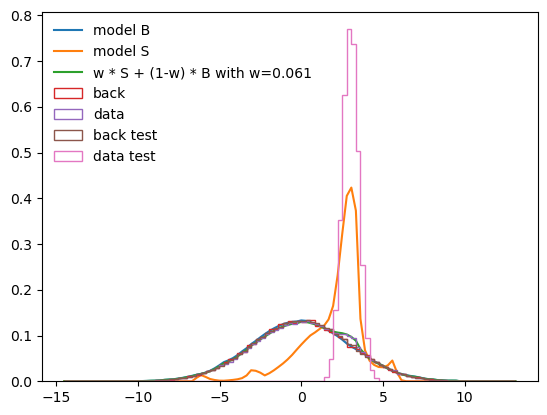

In [27]:
model_B.eval()
model_S.eval()
bins = np.linspace(min(X_train), max(X_train), 100).flatten()

#valloss = np.load('results/nflows_gaussian_mixture_1/m_anode_hyperparam_test/true_likelihood_mode_background_freeze/valloss.npy')
#index = np.argmin(valloss).flatten()[0]
index = 99
print(index)

model_S.load_state_dict(torch.load(f'results/nflows_gaussian_mixture_1/m_anode_hyperparam_test/true_likelihood_mode_background_freeze/model_S_{index}.pt'))
w_ = np.load(f'results/nflows_gaussian_mixture_1/m_anode_hyperparam_test/true_likelihood_mode_background_freeze/w_{index}.npy').item()




Background = model_B.log_prob(torch.from_numpy(bins.reshape(-1,1)).float().to(device)).exp().detach().cpu().numpy()
Signal = model_S.log_prob(torch.from_numpy(bins.reshape(-1,1)).float().to(device)).exp().detach().cpu().numpy()

Data = w_ * Signal + (1-w_) * Background

plt.plot(bins, Background, label='model B')
plt.plot(bins, Signal, label='model S')
plt.plot(bins, Data, label='w * S + (1-w) * B with w=%.3f' % w_)
plt.hist(X_train[y_train==0], bins=bins, label='back' , density=True, histtype='step')
plt.hist(X_train[y_train==1], bins=bins, label='data', density=True, histtype='step')

plt.hist(x_test[label_test==0], bins=bins, label='back test', density=True, histtype='step')
plt.hist(x_test[label_test==1], bins=bins, label='data test', density=True, histtype='step')
plt.legend(frameon=False)
plt.show()


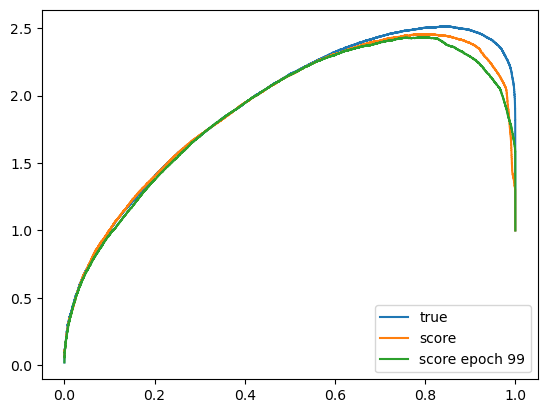

In [25]:
true_likelihoods = {}
true_likelihoods[str(sig_train)] = {}


w1 = true_w[str(sig_train)][0]
w2 = true_w[str(sig_train)][1]

true_likelihoods[str(sig_train)] = p_data(x_test,[sig_mean, back_mean],[sig_simga**2,back_sigma**2],[w1,w2])/p_back(x_test,back_mean,back_sigma**2)


score_likelihoods = {}
score_likelihoods[str(sig_train)] = {}


model_S.eval()
model_B.eval()
with torch.no_grad():
    log_S = model_S.log_prob(testtensor.to(device)).cpu().detach().numpy()
    log_B = model_B.log_prob(testtensor.to(device)).cpu().detach().numpy()

   # data  = w_ * np.exp(log_S) + (1-w_) * np.exp(log_B)
   # back = np.exp(log_B)



    likelihood_2 = log_S - log_B

    likelihood_2 = np.nan_to_num(likelihood_2, nan=0, posinf=0, neginf=0)

  #  score_likelihoods[str(sig_train)] = likelihood_
    

sic_true , tpr_true , auc_true = SIC(label_test, true_likelihoods[str(sig_train)])
sic_score_2 , tpr_score_2 , auc_score_2 = SIC(label_test, likelihood_2)

figure = plt.figure()

plt.plot(tpr_true, sic_true, label='true')
plt.plot(tpr_score, sic_score, label='score')

plt.plot(tpr_score_2, sic_score_2, label='score epoch 99')


plt.legend(loc='lower right')
plt.show()


In [26]:
print(auc_true, auc_score, auc_score_2)

0.9364230207285168 0.9298915682788848 0.9287724823349208


In [57]:
true_w[str(sig_train)][0]

0.021870965217731523

In [16]:
X_train

tensor([[ 1.6612],
        [-1.2352],
        [ 0.6883],
        ...,
        [-0.7990],
        [-3.0925],
        [ 0.6226]])

In [17]:
model_B.eval()
model_S.eval()

model_B.to(device)
model_S.to(device)

with torch.no_grad():
    log_S = model_S.log_prob(X_train.to(device)).cpu().numpy()
    log_B = model_B.log_prob(X_train.to(device)).cpu().numpy()

exp_S = np.exp(log_S)
exp_B = np.exp(log_B)


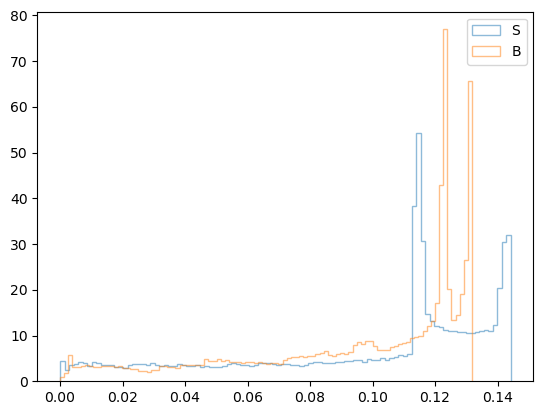

In [18]:
plt.hist(exp_S, bins=100, alpha=0.5, label='S', density=True, histtype='step')
plt.hist(exp_B, bins=100, alpha=0.5, label='B', density=True, histtype='step')
plt.legend()
plt.show()

In [19]:
X_train[(exp_B==0) & (exp_S==0)]

tensor([[-14.5105]])

In [20]:
np.argwhere((exp_B==0) & (exp_S==0))

array([[120407]])

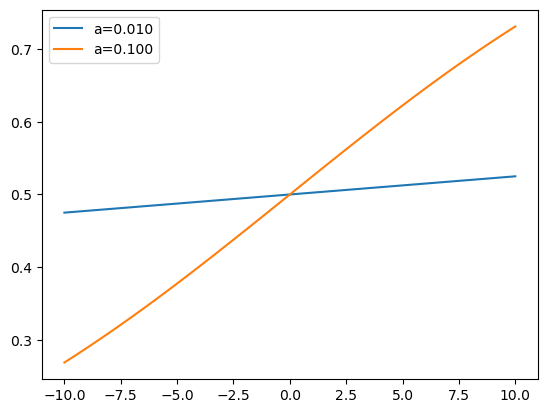

In [31]:
x = np.linspace(-10, 10, 100)
def sigmoid(x, a):
    return 1 / (1 + np.exp(-a*x))

for a in [0.01,0.1]:
    plt.plot(x, sigmoid(x, a), label='a=%.3f' % a)
plt.legend()
plt.show()



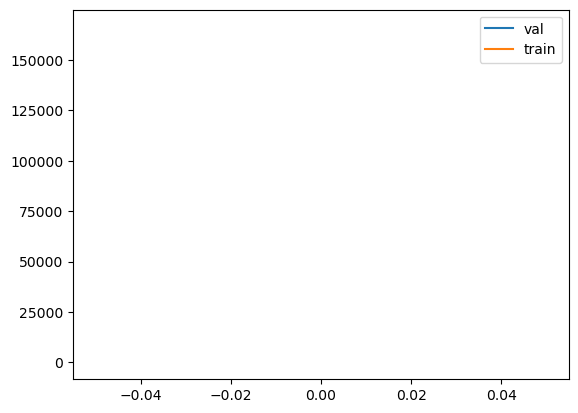

In [ ]:
plt.plot(valloss, label='val')
plt.plot(trainloss, label='train')
plt.legend()
plt.show()

In [ ]:
valloss_list=np.array(valloss_list)
min_epoch=np.argmin(valloss_list)
print('min epoch: ',min_epoch)

NameError: name 'valloss_list' is not defined

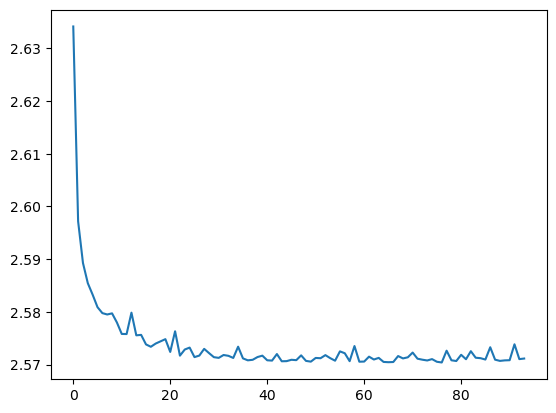

In [ ]:
plt.plot(valloss_list)
plt.show()

In [ ]:
model.load_state_dict(torch.load('models/model_'+str(sig_train)+'/model_SR_'+str(min_epoch)+'.pt'))
model.eval()
with torch.no_grad():
    samples=model.sample(50000)
samples=samples.cpu().detach().numpy().reshape((-1))

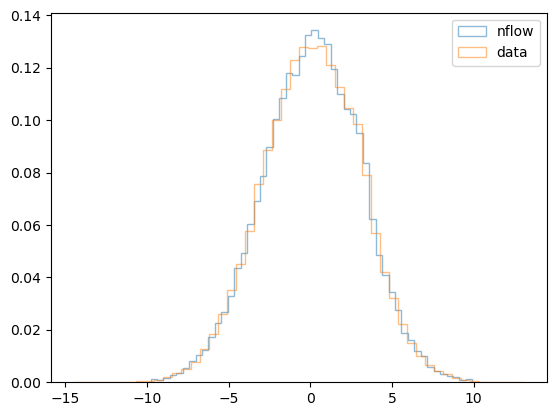

In [ ]:
_=plt.hist(samples,bins=50, density=True, alpha=0.5, histtype='step', label='nflow')
_=plt.hist(x_val,bins=50, density=True, alpha=0.5, histtype='step', label='data')
plt.legend(loc='upper right')
plt.show()

In [ ]:
valloss_list=np.array(valloss_list)
min_epoch=np.argmin(valloss_list)
print('min epoch: ',min_epoch)

min epoch:  76


In [ ]:
background_train , background_val = train_test_split(background, test_size=0.5, random_state=22)

In [ ]:
background_train_tensor = torch.from_numpy(background_train.astype('float32').reshape((-1,1)))
background_val_tensor = torch.from_numpy(background_val.astype('float32').reshape((-1,1)))

In [ ]:
batch_size = 256
background_train_loader = torch.utils.data.DataLoader(background_train_tensor, batch_size=batch_size, shuffle=True)
background_val_loader = torch.utils.data.DataLoader(background_val_tensor, batch_size=batch_size*6, shuffle=False)


In [ ]:
model_background=define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0)

In [ ]:
# train
if not os.path.exists('models/model_'+str(sig_train)):
    os.makedirs('models/model_'+str(sig_train))

valloss_list_background=[]
optimizer = torch.optim.Adam(model_background.parameters(),lr=1e-4) #,lr=1e-4)#, lr=1e-4)

for epoch in range(100):
    print('\n Epoch: {}'.format(epoch))
    train(model_background,optimizer,background_train_loader ,noise_data=0.,noise_context=0.0)
    valloss=val(model_background,background_val_loader)
   # print('epoch '+str(epoch)+' val loss: ',valloss)
    # save model each epoch
    torch.save(model_background.state_dict(), 'models/model_'+str(sig_train)+'/model_CR_'+str(epoch)+'.pt')

    valloss_list_background.append(valloss)
print('done')



 Epoch: 0

 Epoch: 1

 Epoch: 2

 Epoch: 3

 Epoch: 4

 Epoch: 5

 Epoch: 6

 Epoch: 7

 Epoch: 8

 Epoch: 9

 Epoch: 10

 Epoch: 11

 Epoch: 12

 Epoch: 13

 Epoch: 14

 Epoch: 15

 Epoch: 16

 Epoch: 17

 Epoch: 18

 Epoch: 19

 Epoch: 20

 Epoch: 21

 Epoch: 22

 Epoch: 23

 Epoch: 24

 Epoch: 25

 Epoch: 26

 Epoch: 27

 Epoch: 28

 Epoch: 29

 Epoch: 30

 Epoch: 31

 Epoch: 32

 Epoch: 33

 Epoch: 34

 Epoch: 35

 Epoch: 36

 Epoch: 37

 Epoch: 38

 Epoch: 39

 Epoch: 40

 Epoch: 41

 Epoch: 42

 Epoch: 43

 Epoch: 44

 Epoch: 45

 Epoch: 46

 Epoch: 47

 Epoch: 48

 Epoch: 49

 Epoch: 50

 Epoch: 51

 Epoch: 52

 Epoch: 53

 Epoch: 54

 Epoch: 55

 Epoch: 56

 Epoch: 57

 Epoch: 58

 Epoch: 59

 Epoch: 60

 Epoch: 61

 Epoch: 62

 Epoch: 63

 Epoch: 64

 Epoch: 65

 Epoch: 66

 Epoch: 67

 Epoch: 68

 Epoch: 69

 Epoch: 70

 Epoch: 71

 Epoch: 72

 Epoch: 73

 Epoch: 74

 Epoch: 75

 Epoch: 76

 Epoch: 77

 Epoch: 78

 Epoch: 79

 Epoch: 80

 Epoch: 81

 Epoch: 82

 Epoch: 83

 

In [ ]:
valloss_list_background=np.array(valloss_list_background)
min_epoch=np.argmin(valloss_list_background)
print('min epoch: ',min_epoch)

min epoch:  98


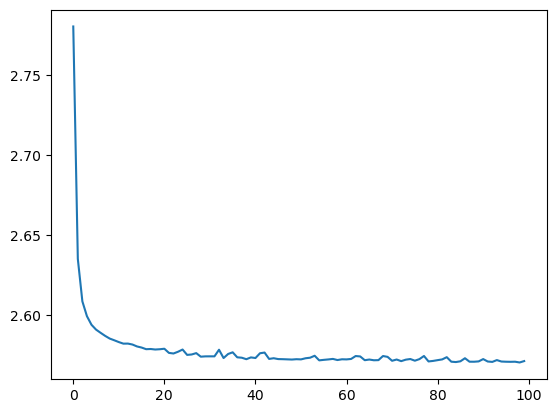

In [ ]:
plt.plot(valloss_list_background)
plt.show()

In [ ]:
min_epoch = 90

model_SR =define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0)
model_SR.load_state_dict(torch.load('models/model_'+str(sig_train)+'/model_SR_'+str(min_epoch)+'.pt'))


<All keys matched successfully>

In [ ]:
min_epoch = 98

model_CR =define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0)
model_CR.load_state_dict(torch.load('models/model_'+str(sig_train)+'/model_CR_'+str(min_epoch)+'.pt'))


<All keys matched successfully>

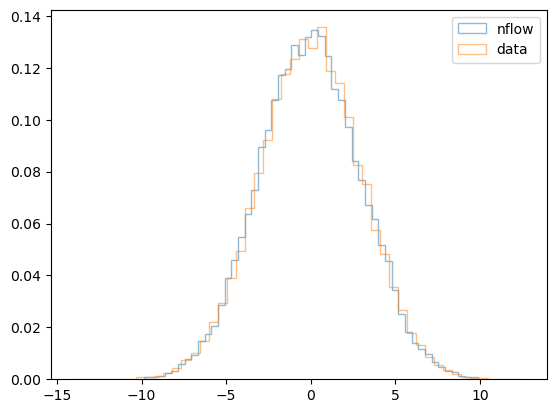

In [ ]:
model_CR.eval()
with torch.no_grad():
    samples=model_CR.sample(50000)
samples=samples.cpu().detach().numpy().reshape((-1))

_=plt.hist(samples,bins=50, density=True, alpha=0.5, histtype='step', label='nflow')
_=plt.hist(background_val,bins=50, density=True, alpha=0.5, histtype='step', label='data')
plt.legend(loc='upper right')
plt.show()

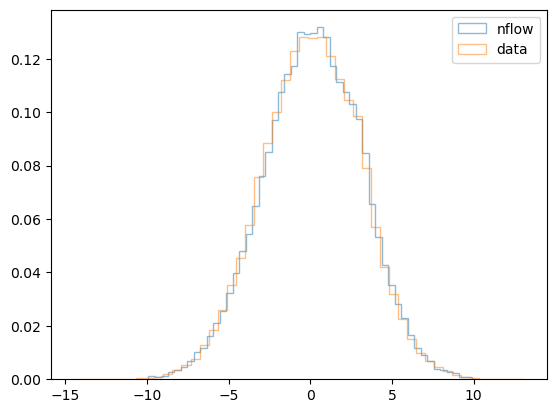

In [ ]:
model_SR.eval()
with torch.no_grad():
    samples=model_SR.sample(100000)
samples=samples.cpu().detach().numpy().reshape((-1))

_=plt.hist(samples,bins=50, density=True, alpha=0.5, histtype='step', label='nflow')
_=plt.hist(x_val,bins=50, density=True, alpha=0.5, histtype='step', label='data')
plt.legend(loc='upper right')
plt.show()

In [ ]:
true_likelihoods = {}

true_likelihoods[str(sig_train)] = {}


w1 = true_w[str(sig_train)][0]
w2 = true_w[str(sig_train)][1]

true_likelihoods[str(sig_train)] = p_data(x_test,[sig_mean, back_mean],[sig_simga**2,back_sigma**2],[w1,w2])/p_back(x_test,back_mean,back_sigma**2)



In [ ]:
score_likelihoods = {}

score_likelihoods[str(sig_train)] = {}

model_SR.eval()
model_CR.eval()
with torch.no_grad():
    log_p = model_SR.log_prob(testtensor.to(device)).cpu().detach().numpy()
    log_q = model_CR.log_prob(testtensor.to(device)).cpu().detach().numpy()
    score_likelihoods[str(sig_train)] = np.exp(log_p - log_q)
    


In [ ]:
label_test

array([0., 0., 0., ..., 1., 1., 1.])

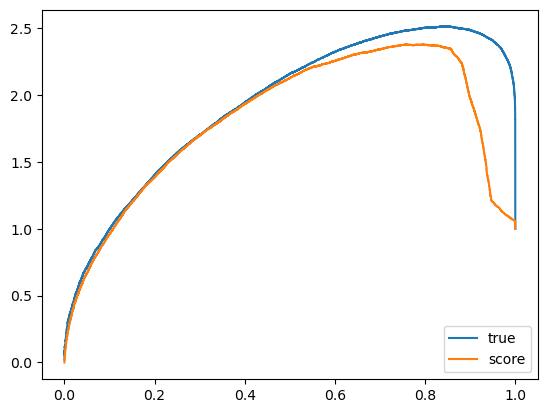

In [ ]:
# compare SICs from score and true likelihoods

sic_true , tpr_true , auc_true = SIC(label_test, true_likelihoods[str(sig_train)])
sic_score , tpr_score , auc_score = SIC(label_test, score_likelihoods[str(sig_train)])

plt.plot(tpr_true, sic_true, label='true')
plt.plot(tpr_score, sic_score, label='score')
plt.legend(loc='lower right')
plt.show()

